# HCI 2019 Week 5 - Spectral Differential Imaging

*Matthew Kenworthy // Leiden Observatory*

Today you will determine the spectral type of a faint companion by comparing the flux of the primary star to the flux of the secondary companion, and then deriving the Methane Spectral Index (MSI), which is a measure of the amount of methane detected in the companion. 

The data is kindly provided by Dr. Beth Biller from the Royal Observatory Edinburgh.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline
import matplotlib.patches as patches


def box(c,x,y,trim=0):
    # chop out a square box from an array
    c2 = np.copy(c)
    (nx,ny) = c.shape
    dx = x - trim
    dy = y - trim
    c2 = c[dy:dy+2*trim,dx:dx+2*trim]
    
    return(c2)

def circle_mask(im, xc, yc, rcirc):
        ny, nx = im.shape
        y,x = np.mgrid[0:nx,0:ny]
        r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
        return ( (r < rcirc))

def r_theta(im, xc, yc):
    # returns the radius rr and the angle phi for point (xc,yc)
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)



# read in the two data cubes
f1, head = fits.getdata('cube_f1.fits', header=True)
f3a, head = fits.getdata('cube_f3a.fits', header=True)

## Details of the observations
The SDI camera uses two narrowband filters, called F1 and F3a, that measure flux in and out of the methane absorption feature in the H band (1.6 microns).

There are two image cubes, one in the F1 band and the other in the F3a band, each containing four separate images.

F1 is at 1.575 microns, and F3a is at 1.625 microns, with a full width of 0.025 microns. Both  filters can be assumed to be 100% transmission inside the filter bandpass and 0% transmission outside the bandpass.

The **Methane Spectral Index (MSI)** is defined as:

$$MSI = \frac{\text{Mean flux in band F1}}{\text{Mean flux in band F3a}} $$

The primary star is called SCR 1845-6357 has a spectral type M8.5, and the secondary companion appears at a separation of 1.170 arcsec from the primary and at a position angle of 170.20 degrees.

The plate scale of the SDI camera is $0.01725\pm0.00025$ arcsec/pixel.


## Measuring MSI from a Spectral Library
Spectra of M, L and T stars in the near-infrared (M and L Dwarf Near-Infrared Standards) have been collected at the SpeX Prism Spectral Libraries:

http://pono.ucsd.edu/~adam/browndwarfs/spexprism/library.html

You should download the `All sources` Zip archive and expand all the spectra into a local directory, and then continue to keep the page open and look at the detailed web pages.

**Q1 (4 points):** Given the spectral type of the primary star (hint: look at the first few lines of each of the spectra files...), find a spectrum with the same spectral type, download it in ascii format, and plot it using `plt.errorbar()`. Make the wavelength go from 1.0 to 2.0 microns, and the normalised flux from 0.0 to 1.0. 

Add a red rectangle to show the wavelength range of the F1 filter and a green rectangle for the wavelength range of the F3a filter. Make sure they have the correct bandwidth, and have an `alpha=0.5` so that you can see the spectrum of the star. 

**HINT** Go read about `matplotlib.patches` and `patches.Rectangle()` using Google...

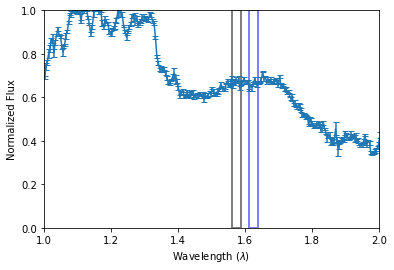

In [58]:
from astropy.io import ascii
spec_star = ascii.read('spex-prism_2MASSJ22021302-0228558_20050908_KIR10A.txt')
wavelength = spec_star['col1']
F_norm = spec_star['col2']
noise = spec_star['col3']


##### Q1 answer below here

fig,ax = plt.subplots(1)
ax.errorbar(wavelength,F_norm,yerr=noise,capsize=3)
F1 = patches.Rectangle((1.575-0.025/2,0),0.025,1,linewidth=2,edgecolor='k',alpha=0.5,facecolor='none')
F3a = patches.Rectangle((1.625 - 0.025/2,0),0.025,1,linewidth=2,edgecolor = 'b',alpha = 0.5,facecolor = 'none')
ax.add_patch(F1)
ax.add_patch(F3a)
plt.xlim(1,2)
plt.ylim(0,1)
plt.xlabel('Wavelength ($\lambda$)')
plt.ylabel('Normalized Flux')
plt.show()





**Q2 (2 points):** Write a function `flux_filter(wlen, flux, wlen0, dwlen)` that calculates the mean flux transmitted through a boxcar filter with central wavelength `wlen0` and filter width `dwlen` and the spectrum is input as `(wlen, flux)`:

In [59]:
def flux_filter(wlen, flux, wlen0, dwlen):
    upper = np.max(np.where(wlen<=wlen0+dwlen/2.))
    lower = np.min(np.where(wlen>=wlen0-dwlen/2.))
    return np.mean(flux[lower:upper])
    
    
print(flux_filter(wavelength,F_norm,1.575,0.025))#F1
print(flux_filter(wavelength,F_norm,1.625,0.025))#F3a
    
# Q2 answer here  
    

0.6719738000000001
0.6591535000000001


**Q3 (1 point):** Calculate the MSI for this M8.5 star, and display it to 2 decimal places.

In [60]:
# Q3 answer here
def calc_MSI(wlen,flux,dwlen):
    F1 = flux_filter(wlen,flux,1.575,dwlen)
    F3a = flux_filter(wlen,flux,1.625,dwlen)
    return np.mean(F1) / np.mean(F3a)

print('MSI for M8.5 star = %.2f' % calc_MSI(wavelength,F_norm,0.025))
    
      


MSI for M8.5 star = 1.02


## Determining the MSI of the secondary companion

**Q4 (6 points):** Measure the flux of the primary star and secondary companion using apertures with a diameter of 0.5 arcseconds.

**HINT:** calculate the diameter of the aperture in pixels and examine the image cubes in ds9.

Make two arrays holding the measured x and y positions of the primary star, and use an offset to determine the position of the secondary companion. Make a loop to go over each of the 4 images, and write out the flux ratio between the primary star and the secondary companion.

**SECOND HINT:** is the background flux surrounding the stars at a level of zero counts? If not, you should measure the background flux and subtract it off the image...

In [61]:
# Q4 answer here
num_pixs = int(np.around(0.5/0.01725))
x = np.array([74,74,50,50])
y = np.array([111,100,100,125])
theta = 180-170.2
theta_rad = theta * np.pi/180
r_planet = 1.170 / 0.01725

def sub_flat(im):
    #subtract sky
    im -= np.median(im)
    #get rid of negative values
    return np.where(im>0,im,0)

f1_new = []
f3a_new = []

for i in range(len(f1)):
    f1_new.append(sub_flat(f1[i]))
    f3a_new.append(sub_flat(f3a[i]))

#Images for next question
f1star_masked = []
f1p_masked = []
f3astar_masked = []
f3ap_masked = []

#planet coordinate
px_coor = []
py_coor = []

#Fluxes
f1_star_flux = []
f1_p_flux = []
f3a_star_flux = []
f3a_p_flux = []

#Ratios
f1_ratio = []
f3a_ratio = []
for i in range(len(f1_new)):
    f1_star_mask = f1_new[i]*circle_mask(f1_new[i],x[i],y[i],num_pixs/2)
    f1star_masked.append(f1_star_mask)
    f1_pposx = x[i] - int(r_planet*np.sin(theta_rad))
    px_coor.append(f1_pposx)
    f1_pposy = y[i] - int(r_planet*np.cos(theta_rad))
    py_coor.append(f1_pposy)
    f1_pmask = f1_new[i] * circle_mask(f1_new[i],f1_pposx,f1_pposy,num_pixs/2)
    f1p_masked.append(f1_pmask)
    f3a_star_mask = f3a_new[i]*circle_mask(f3a_new[i],x[i],y[i],num_pixs/2)
    f3astar_masked.append(f3a_star_mask)
    f3a_pmask = f3a_new[i] * circle_mask(f3a_new[i],f1_pposx,f1_pposy,num_pixs/2)
    f3ap_masked.append(f3a_pmask)
    f1starflux = f1_star_mask[f1_star_mask>0]
    f1_star_flux.append(f1starflux)
    f1pflux = f1_pmask[f1_pmask>0]
    f1_p_flux.append(f1pflux)
    f3astarflux = f3a_star_mask[f3a_star_mask>0]
    f3a_star_flux.append(f3astarflux)
    f3apflux = f3a_pmask[f3a_pmask>0]
    f3a_p_flux.append(f3apflux)
    f1_ratio.append(np.mean(f1starflux) / np.mean(f1pflux))
    f3a_ratio.append(np.mean(f3astarflux) / np.mean(f3apflux))
    
print(f1_ratio)
print(f3a_ratio)

[29.733334, 29.005018, 26.71664, 25.848148]
[65.81057, 63.676983, 57.185833, 43.67982]


**Q5 (2 points) SANITY CHECK** make sure you've got your coordinates right by cutting out a `box(x,y,20)` of the image and displaying it. The star/companion should be in the middle of the box. Have a look at the code below to make a 2x2 array of images, or simply make 4 images from the F1 cube showing that you have the primary star location correct:

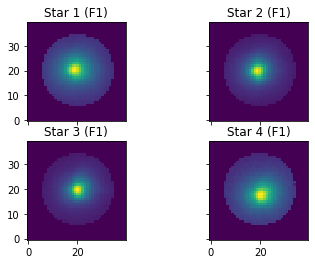

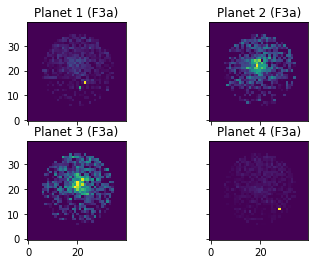

In [62]:
# Q5 sanity check here

# for i in range(len(f1star_masked)):
#     plt.imshow(box(f1star_masked[i],x[i],y[i],20),origin = 'lower')
#     plt.show()

fig, ax = plt.subplots(2,2)
ax[0,0].imshow(box(f1star_masked[0],x[0],y[0],20),origin = 'lower')
ax[0,0].set_title('Star 1 (F1)')
ax[0,1].imshow(box(f1star_masked[1],x[1],y[1],20),origin = 'lower')
ax[0,1].set_title('Star 2 (F1)')
ax[1,0].imshow(box(f1star_masked[2],x[2],y[2],20),origin = 'lower')
ax[1,0].set_title('Star 3 (F1)')
ax[1,1].imshow(box(f1star_masked[3],x[3],y[3],20),origin = 'lower')
ax[1,1].set_title('Star 4 (F1)')
for i in ax.flat:
    i.label_outer()
plt.show()

fig, ax = plt.subplots(2,2)
ax[0,0].imshow(box(f3ap_masked[0],px_coor[0],py_coor[0],20),origin = 'lower')
ax[0,0].set_title('Planet 1 (F3a)')
ax[0,1].imshow(box(f3ap_masked[1],px_coor[1],py_coor[1],20),origin = 'lower')
ax[0,1].set_title('Planet 2 (F3a)')
ax[1,0].imshow(box(f3ap_masked[2],px_coor[2],py_coor[2],20),origin = 'lower')
ax[1,0].set_title('Planet 3 (F3a)')
ax[1,1].imshow(box(f3ap_masked[3],px_coor[3],py_coor[3],20),origin = 'lower')
ax[1,1].set_title('Planet 4 (F3a)')
for i in ax.flat:
    i.label_outer()
plt.show()

**Q6 (2 points): ** Now you have 4 measurements of flux ratio at F1 and at F3a for the primary star compared to the secondary companion, calculate the MSI for the secondary companion and estimate an error using `np.mean()` and `np.std()`

In [63]:
# Q6 answer here

from uncertainties import ufloat

MSI = []
MSI_err = []
for i in range(len(f1_star_flux)):
    MSI.append(np.mean(f1_p_flux[i]) / np.mean(f3a_p_flux[i]))
    MSI_err.append(np.nanstd(f1_p_flux[i]) / np.nanstd(f3a_p_flux[i]))
    
print(MSI)
print(MSI_err)

MSI_comp = []

for i in range(len(MSI)):
    MSI_comp.append(ufloat(MSI[i],MSI_err[i]))
    
print('MSI of Companion = ', np.median(MSI_comp))

#That seems to be a pretty large error :(

[1.9532987, 1.9295888, 1.872463, 1.4420701]
[1.443307, 2.1553526, 2.0814023, 0.723504]
MSI of Companion =  1.9+/-1.5


## Comapring your result to Biller et al. (2006)
The measured methane spectral index in Biller et al. (2006) is $2.7 \pm 0.1$

**Q7 (2 points):** Is there a significant difference between your MSI and that in the paper? If YES, why? Are your propagated errors larger than Biller's measurements? If YES, why?

# Q7 answer here

## There does seem to be a decent difference in the resulting MSI and especially the error along with it.  This would most likely result from better image cleaning.  


## Determining the spectral type of the secondary companion

**Q8 (6 points):** Construct a plot showing spectral type along the x-axis with methane spectral index on the y-axis. Go to the SPeX webpage, and download the L dwarf and T dwarf spectral libraries.

Pick a star from every **Near IR spectral type** subtype from L6 to T9 (i.e. L6, L7, L8, L9, T0, T1...), calculate the Methane Spectral Index, and plot it below. (**HINT:** it is easier to have a number represent the spectra type, i.e. 6 = L6, 8 = L8, 10 = T0....)

Overplot your measured Methane Spectral Index for the secondary companion and determine what spectral type the companion is. Take the errors from your 4 measurements of MSI to estimate by eye an error in spectral type.

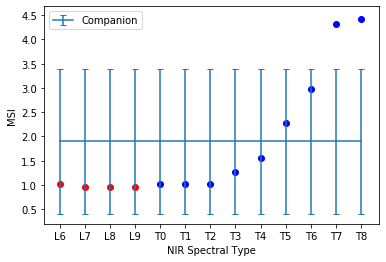

In [83]:
# Q8 answer here
Ltypes = ['spex-prism_2MASSJ22120703+3430351_20051019_KIR10A.txt',
          'spex-prism_SDSSJ104409.43+042937.6_20080110_BUR10A.txt',
          'spex-prism_SDSSJ121951.45+312849.4_20061224_BUR10A.txt',
          'spex-prism_SDSSJ104335.08+121314.1_20060531_KIR10A.txt'
         ]
Ttypes = ['spex-prism_SDSSJ120747.17+024424.8_20061221_LOO07A.txt',
          'spex-prism_SDSSJ085834.42+325627.7_20050123_CHI06A.txt',
          'spex-prism_SDSSJ075840.33+324723.4_20061223_BUR08B.txt',
          'spex-prism_SDSSJ102109.69-030420.1_20040312_BUR06C.txt',
          'spex-prism_2MASSIJ2254188+312349_20030918_BUR04B.txt',
          'spex-prism_SDSSJ074201.41+205520.5_20080110_BUR10A.txt',
          'spex-prism_SDSSpJ162414.37+002915.6_20040312_BUR06D.txt',
          'spex-prism_2MASSIJ0727182+171001_20040310_BUR06D.txt',
          'spex-prism_2MASSJ09393548-2448279_20040312_BUR06D.txt'
         ]
spec_num = ['L6','L7','L8','L9','T0','T1','T2','T3','T4','T5','T6','T7','T8']

comp_MSI = np.median(MSI_comp)

for i in range(len(Ltypes)):
    star_spec = ascii.read(Ltypes[i])
    lam = star_spec['col1']
    flux = star_spec['col2']
    plt.scatter(spec_num[i],calc_MSI(lam,flux,0.025),color = 'r')
for i in range(len(Ttypes)):
    star_spec = ascii.read(Ttypes[i])
    lam = star_spec['col1']
    flux = star_spec['col2']
    plt.scatter(spec_num[i+4],calc_MSI(lam,flux,0.025),color = 'b')

plt.errorbar(spec_num,([comp_MSI.nominal_value]*13), yerr =([comp_MSI.std_dev]*13),label = 'Companion',
            capsize = 3)
plt.xlabel('NIR Spectral Type')
plt.ylabel('MSI')
plt.legend()
plt.show()



### Most of the spectral types fit within the error calculated for the companion.  But it looks like T4.5 would be the closest fit based on the behavior of the data

**Please put down the number of hours you spent on this Practicum in the cell below**


# 6 Hours